In [1]:
import os
import boto3
from dotenv import load_dotenv
import io 
import pandas as pd

load_dotenv()

YC_ACCESS_KEY_ID = os.getenv("YC_ACCESS_KEY_ID")
YC_SECRET_ACCESS_KEY = os.getenv("YC_SECRET_ACCESS_KEY")
YC_ENDPOINT_URL = os.getenv("YC_ENDPOINT_URL")
YC_BUCKET_NAME = os.getenv("YC_BUCKET_NAME")

In [2]:
session = boto3.session.Session()
s3_client = session.client(
    service_name='s3',
    endpoint_url=YC_ENDPOINT_URL,
    aws_access_key_id=YC_ACCESS_KEY_ID,
    aws_secret_access_key=YC_SECRET_ACCESS_KEY
)

# Загрузка данных

In [3]:
import gzip

file_names = ["item_categories.csv.gzip", "items.csv.gzip", "sample_submission.csv.gzip", "shops.csv.gzip", "test.csv.gzip"]
data_location = "compressed_data/"

data_storage = dict()
for file_name in file_names:
    response = s3_client.get_object(Bucket=YC_BUCKET_NAME, Key=f'{data_location}{file_name}')
    data_storage[file_name[: len(file_name) - 9]] = pd.read_csv(io.BytesIO(response['Body'].read()), compression='gzip')




In [4]:
response = s3_client.get_object(Bucket=YC_BUCKET_NAME, Key=f'filtered_data/train.csv.gzip')
train = pd.read_csv(io.BytesIO(response['Body'].read()), compression='gzip')

# Дополнительные обработки

In [5]:
import matplotlib.pyplot as plt

In [6]:
monthly_sales = train.groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False).agg(
    item_cnt_month=('item_cnt_day', 'sum')
)

Группировка по месяцам имеет смысл тк <br>

Продажи по месяцам имеют более предсказуемый характер<br>
Целевая переменная в test должна считается в месяцах


([<matplotlib.axis.XTick at 0x76f41a146060>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20'),
  Text(21, 0, '21'),
  Text(22, 0, '22'),
  Text(23, 0, '23'),
  Text(24, 0, '24'),
  Text(25, 0, '25'),
  Text(26, 0, '26'),
  Text(27, 0, '27'),
  Text(28, 0, '28'),
  Text(29, 0, '29'),
  Text(30, 0, '30'),
  Text(31, 0, '31'),
  Text(32, 0, '32'),
  Text(33, 0, '33')])

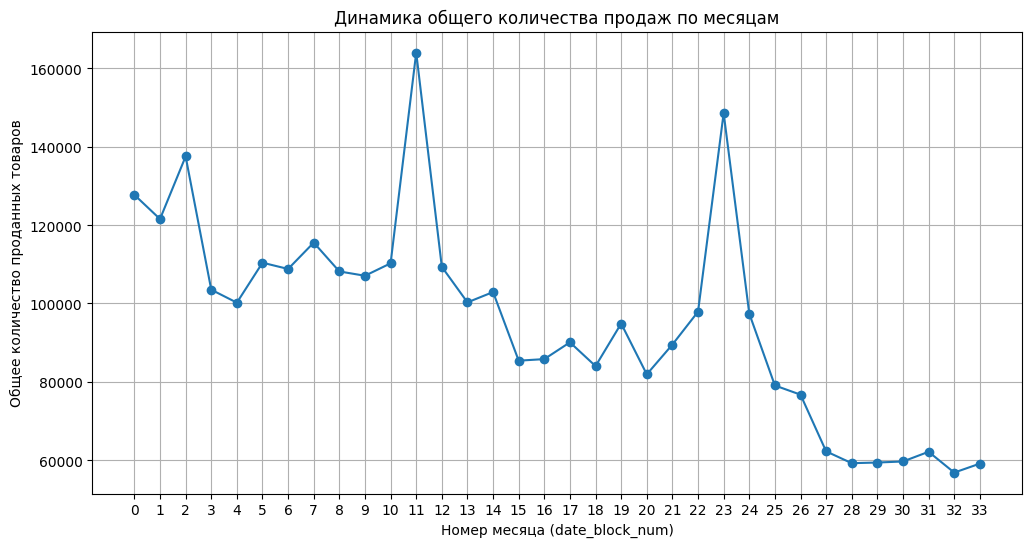

In [7]:
total_monthly_sales = monthly_sales.groupby('date_block_num')['item_cnt_month'].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(total_monthly_sales['date_block_num'], total_monthly_sales['item_cnt_month'], marker='o', linestyle='-')
plt.title('Динамика общего количества продаж по месяцам')
plt.xlabel('Номер месяца (date_block_num)')
plt.ylabel('Общее количество проданных товаров')
plt.grid(True)
plt.xticks(total_monthly_sales['date_block_num'])

Наблюдается нисходящий тренд и сезонность с пиками перед Новым годом.

# Feature Engenering

In [8]:
sales_with_items = pd.merge(monthly_sales, data_storage['items'], on='item_id', how='left')

merged_test = pd.merge(sales_with_items, data_storage['item_categories'], on='item_category_id', how='left')
merged_test.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_name,item_category_id,item_category_name
0,0,0,32,6.0,1+1,40,Кино - DVD
1,0,0,33,3.0,1+1 (BD),37,Кино - Blu-Ray
2,0,0,35,1.0,10 ЛЕТ СПУСТЯ,40,Кино - DVD
3,0,0,43,1.0,100 МИЛЛИОНОВ ЕВРО,40,Кино - DVD
4,0,0,51,2.0,100 лучших произведений классики (mp3-CD) (Dig...,57,Музыка - MP3


Смысла в добавлении названий товаров и категорий особо нет тк и там и там категориальные фичи которые.<br>
Добавим только идентификатор категории товара 

In [11]:
sales_with_category_id = pd.merge(monthly_sales, data_storage["items"][['item_id', 'item_category_id']], on='item_id', how='left')


In [12]:
sales_with_category_id.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_category_id
0,0,0,32,6.0,40
1,0,0,33,3.0,37
2,0,0,35,1.0,40
3,0,0,43,1.0,40
4,0,0,51,2.0,57


In [ ]:
# import itertools

# all_dates = monthly_sales['date_block_num'].unique()
# all_shops = data_storage['shops']['shop_id'].unique()
# all_items = data_storage["items"]['item_id'].unique()


# grid = list(itertools.product(all_dates, all_shops, all_items))
# grid_df = pd.DataFrame(grid, columns=['date_block_num', 'shop_id', 'item_id'])

# full_sales_grid = pd.merge(
#     grid_df,
#     monthly_sales,
#     on=['date_block_num', 'shop_id', 'item_id'],
#     how='left'
# )

# full_sales_grid['item_cnt_month'] = full_sales_grid['item_cnt_month'].fillna(0)

# print("Полная сетка продаж:")
# print(full_sales_grid)

Полная сетка продаж:
          date_block_num  shop_id  item_id  item_cnt_month
0                      0        0        0             0.0
1                      0        0        1             0.0
2                      0        0        2             0.0
3                      0        0        3             0.0
4                      0        0        4             0.0
...                  ...      ...      ...             ...
45226795              33       59    22165             0.0
45226796              33       59    22166             0.0
45226797              33       59    22167             0.0
45226798              33       59    22168             0.0
45226799              33       59    22169             0.0

[45226800 rows x 4 columns]


Дополнили поля в которых не было данных о продажах 0.

Оказалось слишком много машазинов которые никогда не продавали многие товары.<br>
Слишком сильно раздувает датасет

In [15]:
full_sales_grid = sales_with_category_id.sort_values(['shop_id', 'item_id', 'date_block_num']).reset_index(drop=True)

full_sales_grid['item_cnt_month_3m_avg'] = full_sales_grid.groupby(['shop_id', 'item_id'])['item_cnt_month'].rolling(
    window=3, min_periods=1
).mean().reset_index(level=[0, 1], drop=True)

full_sales_grid['item_cnt_month_6m_avg'] = full_sales_grid.groupby(['shop_id', 'item_id'])['item_cnt_month'].rolling(
    window=6, min_periods=1
).mean().reset_index(level=[0, 1], drop=True)

full_sales_grid['item_cnt_month_12m_avg'] = full_sales_grid.groupby(['shop_id', 'item_id'])['item_cnt_month'].rolling(
    window=12, min_periods=1
).mean().reset_index(level=[0, 1], drop=True)

full_sales_grid['item_cnt_month_3m_avg'] = full_sales_grid.groupby(['shop_id', 'item_id'])['item_cnt_month_3m_avg'].shift(1)
full_sales_grid['item_cnt_month_6m_avg'] = full_sales_grid.groupby(['shop_id', 'item_id'])['item_cnt_month_6m_avg'].shift(1)
full_sales_grid['item_cnt_month_12m_avg'] = full_sales_grid.groupby(['shop_id', 'item_id'])['item_cnt_month_12m_avg'].shift(1)


full_sales_grid['item_cnt_month_3m_avg'] = full_sales_grid['item_cnt_month_3m_avg'].fillna(0)
full_sales_grid['item_cnt_month_6m_avg'] = full_sales_grid['item_cnt_month_6m_avg'].fillna(0)
full_sales_grid['item_cnt_month_12m_avg'] = full_sales_grid['item_cnt_month_12m_avg'].fillna(0)


Добавили данные о среднем количестве продаж за последние 3 6 и 12 месяцев<br>



In [23]:
full_sales_grid = full_sales_grid.sort_values(['shop_id', 'item_id', 'date_block_num']).reset_index(drop=True)

df_lag_3 = full_sales_grid.copy()
df_lag_6 = full_sales_grid.copy()
df_lag_12 = full_sales_grid.copy()

def create_lags(df, lag_count):
    df_with_lags = df.copy()
    for lag in range(1, lag_count + 1):
        df_with_lags[f'item_cnt_month_lag_{lag}'] = df_with_lags.groupby(['shop_id', 'item_id'])['item_cnt_month'].shift(lag)
    
    df_with_lags = df_with_lags.fillna(0)
    return df_with_lags

df_lag_3 = create_lags(full_sales_grid, 3)
df_lag_6 = create_lags(full_sales_grid, 6)
df_lag_12 = create_lags(full_sales_grid, 12)


# Выгрузка данных

In [25]:
datasets_to_save = [full_sales_grid, df_lag_3, df_lag_6, df_lag_12]
file_names = ["0m_lags.csv.gzip", "3m_lags.csv.gzip", "6m_lags.csv.gzip", "12m_lags.csv.gzip"]

location = "final_train_datasets/"

for file_name, df in zip(file_names, datasets_to_save):
    buffer = io.BytesIO()

    df.to_csv(buffer, index=False, compression='gzip')
    buffer.seek(0)

    s3_client.upload_fileobj(buffer, YC_BUCKET_NAME, f"{location}{file_name}")
    
    print(f"Файл '{file_name}' успешно загружен в бакет '{YC_BUCKET_NAME}'.")


Файл '0m_lags.csv.gzip' успешно загружен в бакет 'innowiseintershipdata'.
Файл '3m_lags.csv.gzip' успешно загружен в бакет 'innowiseintershipdata'.
Файл '6m_lags.csv.gzip' успешно загружен в бакет 'innowiseintershipdata'.
Файл '12m_lags.csv.gzip' успешно загружен в бакет 'innowiseintershipdata'.
